In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import torch
from torch.utils.data import DataLoader, TensorDataset

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 1: Load the dataset
file_path = r'C:\Users\Dustin\Documents\Github\LOL-Match\league_of_legends_data_large.csv'
data = pd.read_csv(file_path)

# Step 2: Feature Engineering
# Add 'kda', 'gold_per_minion', 'vision_score' features
data['kda'] = (data['kills'] + data['assists']) / (data['deaths'] + 1)
data['gold_per_minion'] = data['gold_earned'] / (data['cs'] + 1)
data['vision_score'] = data['wards_placed'] + data['wards_killed']

# Step 3: Remove Outliers (using z-score threshold of 3)
from scipy.stats import zscore

# Removing outliers from key features based on z-score > 3
key_features = ['kills', 'deaths', 'assists', 'gold_earned', 'cs', 'wards_placed', 'wards_killed', 'damage_dealt']
data = data[(np.abs(zscore(data[key_features])) < 3).all(axis=1)]

# Step 4: Split into features and target
X = data.drop(columns=['win'])
y = data['win']

# Step 5: Balance the Classes using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Step 6: Standardize the features (using MinMaxScaler)
scaler = MinMaxScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

# Step 7 (Optional): Dimensionality Reduction with PCA (reduce to 8 features)

# Step 8: Split the resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled_scaled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Step 9: Convert the data into PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Step 10: Create DataLoader for training and test sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("New Dataset Shape after SMOTE and PCA:", X_train.shape)

Using device: cuda
New Dataset Shape after SMOTE and PCA: (816, 11)


In [25]:
import torch.nn as nn
import torch.optim as optim

# Define the model
class LOLMatchClassifier(nn.Module):
    def __init__(self, input_size):
        super(LOLMatchClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # Increased number of neurons
        self.bn1 = nn.BatchNorm1d(128)  # Batch normalization
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)  # Dropout for regularization
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)  # Output layer (1 output for binary classification)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.relu(x)
        x = torch.sigmoid(self.fc4(x))  # Sigmoid for binary output between 0 and 1
        return x

# Instantiate the model
model = LOLMatchClassifier(X_train.shape[1])
model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()  # Ensure target is float for BCELoss
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()  # Ensure outputs shape matches y_batch shape
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluate the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch).squeeze()
        predicted = (outputs >= 0.5).float()  # Apply threshold of 0.5
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")

Epoch 1/50, Loss: 0.6933
Epoch 2/50, Loss: 0.6946
Epoch 3/50, Loss: 0.6896
Epoch 4/50, Loss: 0.6910
Epoch 5/50, Loss: 0.6964
Epoch 6/50, Loss: 0.6930
Epoch 7/50, Loss: 0.6864
Epoch 8/50, Loss: 0.6887
Epoch 9/50, Loss: 0.6899
Epoch 10/50, Loss: 0.6856
Epoch 11/50, Loss: 0.6884
Epoch 12/50, Loss: 0.6831
Epoch 13/50, Loss: 0.6893
Epoch 14/50, Loss: 0.6920
Epoch 15/50, Loss: 0.6857
Epoch 16/50, Loss: 0.6880
Epoch 17/50, Loss: 0.6824
Epoch 18/50, Loss: 0.6865
Epoch 19/50, Loss: 0.6845
Epoch 20/50, Loss: 0.6885
Epoch 21/50, Loss: 0.6834
Epoch 22/50, Loss: 0.6828
Epoch 23/50, Loss: 0.6772
Epoch 24/50, Loss: 0.6829
Epoch 25/50, Loss: 0.6865
Epoch 26/50, Loss: 0.6837
Epoch 27/50, Loss: 0.6750
Epoch 28/50, Loss: 0.6880
Epoch 29/50, Loss: 0.6838
Epoch 30/50, Loss: 0.6803
Epoch 31/50, Loss: 0.6763
Epoch 32/50, Loss: 0.6788
Epoch 33/50, Loss: 0.6810
Epoch 34/50, Loss: 0.6794
Epoch 35/50, Loss: 0.6803
Epoch 36/50, Loss: 0.6713
Epoch 37/50, Loss: 0.6824
Epoch 38/50, Loss: 0.6747
Epoch 39/50, Loss: 0.

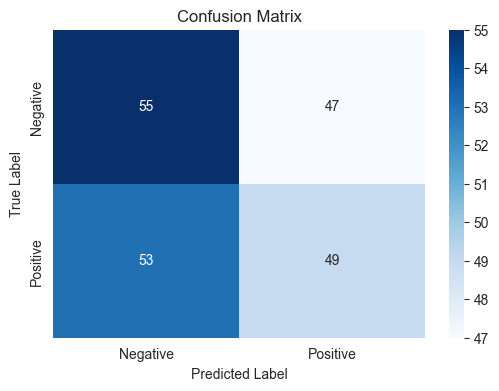

Classification Report:
              precision    recall  f1-score   support

    Negative       0.51      0.54      0.52       102
    Positive       0.51      0.48      0.49       102

    accuracy                           0.51       204
   macro avg       0.51      0.51      0.51       204
weighted avg       0.51      0.51      0.51       204



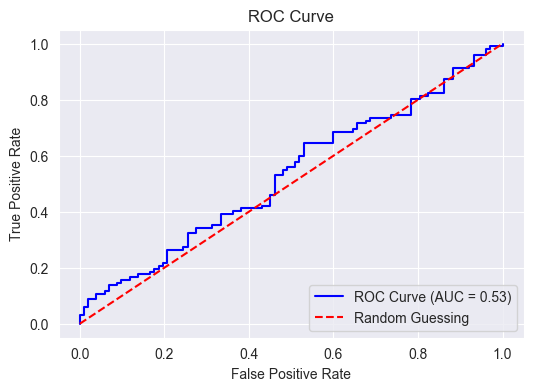

In [26]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Set model to evaluation mode
model.eval()

# Initialize lists to store true labels, predicted labels, and probabilities
y_true = []
y_pred = []
y_prob = []

# Ensure the model is on the correct device (CPU in this case)
device = torch.device("cpu")
model.to(device)

# Iterate over the test data
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        # Move batch data to the same device as the model
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Get model outputs
        outputs = model(X_batch).squeeze()  # Squeeze to remove unnecessary dimensions

        # Convert outputs to probabilities (since sigmoid is already applied in the model)
        probabilities = outputs.cpu().numpy()  # Get the probabilities (values between 0 and 1)

        # Convert probabilities to predicted class labels (0 or 1) using a threshold of 0.5
        predictions = (probabilities >= 0.5).astype(int)

        # Collect true labels, predicted labels, and probabilities
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predictions)
        y_prob.extend(probabilities)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [27]:
import copy

# Learning rates and weight decays to explore
learning_rates = [0.001, 0.01, 0.1, 0.2, 0.5]
weight_decays = [0.0001, 0.001, 0.01, 0.1, 0.5]

# Variables to track the best hyperparameters
best_lr = None
best_weight_decay = None
best_accuracy = 0
best_model_state = None

# Training device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loop through learning rates and weight decays
for lr in learning_rates:
    for wd in weight_decays:
        print(f"Testing learning rate: {lr}, weight decay: {wd}")

        # Reinitialize the model
        model = LOLMatchClassifier(X_train.shape[1])
        model.to(device)

        # Define the loss function and optimizer
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

        # Training Loop
        epochs = 50
        for epoch in range(epochs):
            model.train()
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()  # Ensure target is float for BCELoss
                optimizer.zero_grad()
                outputs = model(X_batch).squeeze()  # Squeeze to match target dimensions
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

        # Evaluate the model on the test set
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch).squeeze()
                predictions = (outputs >= 0.5).float()  # Apply threshold of 0.5
                total += y_batch.size(0)
                correct += (predictions == y_batch).sum().item()

        accuracy = correct / total * 100

        print(f"Learning Rate: {lr}, Weight Decay: {wd}, Test Accuracy: {accuracy:.4f}%")

        # Update best learning rate, weight decay, and save the model state if better
        if accuracy > best_accuracy:
            best_lr = lr
            best_weight_decay = wd
            best_accuracy = accuracy
            best_model_state = copy.deepcopy(model.state_dict())

# Print the best hyperparameters
print(f"Best Learning Rate: {best_lr}, Best Weight Decay: {best_weight_decay}, Best Test Accuracy: {best_accuracy:.4f}%")

# # Load the best model state for future use
if best_model_state:
    model.load_state_dict(best_model_state)

Testing learning rate: 0.001, weight decay: 0.0001
Learning Rate: 0.001, Weight Decay: 0.0001, Test Accuracy: 54.9020%
Testing learning rate: 0.001, weight decay: 0.001
Learning Rate: 0.001, Weight Decay: 0.001, Test Accuracy: 51.9608%
Testing learning rate: 0.001, weight decay: 0.01
Learning Rate: 0.001, Weight Decay: 0.01, Test Accuracy: 54.9020%
Testing learning rate: 0.001, weight decay: 0.1
Learning Rate: 0.001, Weight Decay: 0.1, Test Accuracy: 50.0000%
Testing learning rate: 0.001, weight decay: 0.5
Learning Rate: 0.001, Weight Decay: 0.5, Test Accuracy: 50.0000%
Testing learning rate: 0.01, weight decay: 0.0001
Learning Rate: 0.01, Weight Decay: 0.0001, Test Accuracy: 51.9608%
Testing learning rate: 0.01, weight decay: 0.001
Learning Rate: 0.01, Weight Decay: 0.001, Test Accuracy: 51.4706%
Testing learning rate: 0.01, weight decay: 0.01
Learning Rate: 0.01, Weight Decay: 0.01, Test Accuracy: 50.0000%
Testing learning rate: 0.01, weight decay: 0.1
Learning Rate: 0.01, Weight Dec

                   Feature    Weight
8    Principal Component 9  0.001447
2    Principal Component 3  0.001154
1    Principal Component 2  0.000784
5    Principal Component 6  0.000489
9   Principal Component 10  0.000292
3    Principal Component 4  0.000259
0    Principal Component 1 -0.000442
7    Principal Component 8 -0.001045
4    Principal Component 5 -0.001129
6    Principal Component 7 -0.001382
10  Principal Component 11 -0.001882


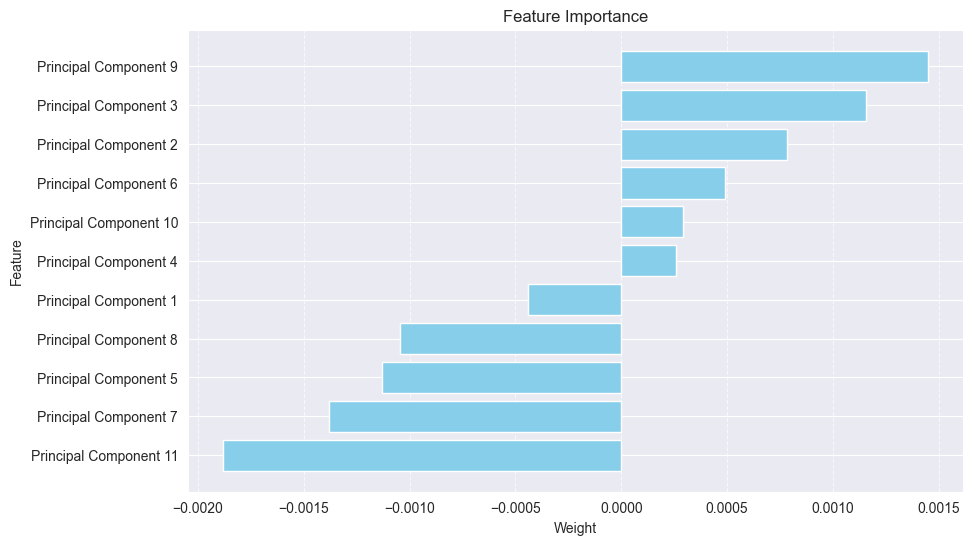

In [29]:
# Extract weights from the first layer of the model (fc1)
feature_weights = model.fc1.weight.detach().cpu().numpy()

# Since fc1 has an output of size 128, you will have 128 rows of weights,
# each corresponding to the connection of input features to each neuron in the hidden layer.
# To obtain overall feature importance, we can take the mean of the absolute weights across all neurons.

# Compute the mean absolute weights for each input feature
mean_feature_weights = feature_weights.mean(axis=0)

# Create a DataFrame for feature importance
import pandas as pd
n_components = X_train.shape[1]  # Number of features after PCA
feature_names = [f"Principal Component {i+1}" for i in range(n_components)]  # Replace with actual column names if using a DataFrame
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Weight": mean_feature_weights
}).sort_values(by="Weight", ascending=False)

print(importance_df)

# Plot feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Weight"], color="skyblue")
plt.xlabel("Weight")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()